# Protein Folding Problem

## content

[i.ProteinFoldingProblem function](#i.ProteinFoldingProblemfunction)<br>
&nbsp; [1.ProteinDefining](#1.ProteinDefining)<br>
&nbsp; [2.InteractionMethod](#2.InteractionMethod)<br>
&nbsp; [3.PenaltyTerms](#3.PenaltyTerms)<br>
[ii.ConvertToQubits](#ii.ConvertToQubits)<br>
[iii.VQEwithCVaRexpectation](#iii.VQEwithCVaRexpectation)<br>
&nbsp; [1.ansatz](#1.ansatz)<br>
&nbsp; [2.optimizer](#2.optimizer)<br>
&nbsp; [3.backend](#3.backend)<br>
&nbsp; [4.expectation](#4.expectation)<br>
[iv.AnalysingTheResults](#iv.AnalysingTheResults)<br>

##  i.ProteinFoldingProblemfunction

### 1.ProteinDefining

In [1]:
# To simplify the problem, we only consider the main chain and omit the side chain 
main_chain = "APRLRFY" # 9 amino acids

In [2]:
def validate_main_chain(main_chain: str):
    for amino_acid in main_chain:
        if validate_amino_acid(amino_acid) == False:
            return False
    return True


def validate_amino_acid(amino_acid: str) -> bool:
    valid_amino_acids = [
        "A",  # Alanine
        "C",  # Cysteine
        "D",  # Aspartic acid
        "E",  # Glutamic acid
        "F",  # Phenylalanine
        "G",  # Glycine
        "H",  # Histidine
        "I",  # Isoleucine
        "K",  # Lysine
        "L",  # Leucine
        "M",  # Methionine
        "N",  # Asparagine
        "P",  # Proline
        "Q",  # Glutamine
        "R",  # Arginine
        "S",  # Serine
        "T",  # Threonine
        "V",  # Valine
        "W",  # Tryptophan
        "Y",  # Tyrosine
    ]
    if amino_acid != "" and amino_acid not in valid_amino_acids:
        return False
    return True


In [3]:
validate_main_chain(main_chain)

True

### 2.InteractionMethod

In [4]:
from pathlib import Path
import os
import numpy as np
from typing import Tuple, List

def path_of_mj():
    path1 = Path().parent.absolute()
    path2 = Path("resources")
    path1 = os.path.join(path1, path2)
    filename = "mj_matrix.txt"
    path = os.path.normpath(os.path.join(path1, filename))
    return path

def mj_matrix(matrix: np.ndarray) -> np.ndarray:
    energy_matrix = np.zeros((np.shape(matrix)[0], np.shape(matrix)[1]))
    for row in range(1, np.shape(matrix)[0]):
        for col in range(row - 1, np.shape(matrix)[1]):
            energy_matrix[row, col] = float(matrix[row, col])
    energy_matrix = energy_matrix[
        1:,
    ]
    return energy_matrix

def load_mj_matrix() -> Tuple[np.ndarray, List[str]]:
    path = path_of_mj()
    matrix = np.loadtxt(fname=path, dtype=str)
    energy_matrix = mj_matrix(matrix)
    amino_acids = list(matrix[0, :])
    return energy_matrix, amino_acids

def calculate_energy_matrix(main_chain: str) -> np.ndarray:
        chain_len = len(main_chain)
        validate_main_chain(main_chain) 
        mj_interaction, list_amino_acids = load_mj_matrix() 
        pair_energies = np.zeros((chain_len + 1, 2, chain_len + 1, 2))
        for i in range(1, chain_len + 1):
            for j in range(i + 1, chain_len + 1):
                aa_i = list_amino_acids.index(main_chain[i - 1])
                aa_j = list_amino_acids.index(main_chain[j - 1])
                pair_energies[i, 0, j, 0] = mj_interaction[min(aa_i, aa_j), max(aa_i, aa_j)]
        return pair_energies

In [5]:
### MJ interaction table
mj, amino_acids = load_mj_matrix()
print(amino_acids)

['C', 'M', 'F', 'I', 'L', 'V', 'W', 'Y', 'A', 'G', 'T', 'S', 'N', 'Q', 'D', 'E', 'H', 'R', 'K', 'P']


In [6]:
print(mj)

[[-5.44 -4.99 -5.8  -5.5  -5.83 -4.96 -4.95 -4.16 -3.57 -3.16 -3.11 -2.86
  -2.59 -2.85 -2.41 -2.27 -3.6  -2.57 -1.95 -3.07]
 [ 0.   -5.46 -6.56 -6.02 -6.41 -5.32 -5.55 -4.91 -3.94 -3.39 -3.51 -3.03
  -2.95 -3.3  -2.57 -2.89 -3.98 -3.12 -2.48 -3.45]
 [ 0.    0.   -7.26 -6.84 -7.28 -6.29 -6.16 -5.66 -4.81 -4.13 -4.28 -4.02
  -3.75 -4.1  -3.48 -3.56 -4.77 -3.98 -3.36 -4.25]
 [ 0.    0.    0.   -6.54 -7.04 -6.05 -5.78 -5.25 -4.58 -3.78 -4.03 -3.52
  -3.24 -3.67 -3.17 -3.27 -4.14 -3.63 -3.01 -3.76]
 [ 0.    0.    0.    0.   -7.37 -6.48 -6.14 -5.67 -4.91 -4.16 -4.34 -3.92
  -3.74 -4.04 -3.4  -3.59 -4.54 -4.03 -3.37 -4.2 ]
 [ 0.    0.    0.    0.    0.   -5.52 -5.18 -4.62 -4.04 -3.38 -3.46 -3.05
  -2.83 -3.07 -2.48 -2.67 -3.58 -3.07 -2.49 -3.32]
 [ 0.    0.    0.    0.    0.    0.   -5.06 -4.66 -3.82 -3.42 -3.22 -2.99
  -3.07 -3.11 -2.84 -2.99 -3.98 -3.41 -2.69 -3.73]
 [ 0.    0.    0.    0.    0.    0.    0.   -4.17 -3.36 -3.01 -3.01 -2.78
  -2.76 -2.97 -2.76 -2.79 -3.52 -3.16 -2.6  -3.19]


In [7]:
### Calculating energy for the special peptide
miyazawa_jernigan=calculate_energy_matrix(main_chain)
print(miyazawa_jernigan)

[[[[ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]]

  [[ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]]]


 [[[ 0.    0.  ]
   [ 0.    0.  ]
   [-2.03  0.  ]
   [-1.83  0.  ]
   [-4.91  0.  ]
   [-1.83  0.  ]
   [-4.81  0.  ]
   [-3.36  0.  ]]

  [[ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]]]


 [[[ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [-1.7   0.  ]
   [-4.2   0.  ]
   [-1.7   0.  ]
   [-4.25  0.  ]
   [-3.19  0.  ]]

  [[ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]]]


 [[[ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [ 0.    0.  ]
   [-4.03  0.  ]
   [-1.55  0.  ]
   [-3.98  0.  ]
   [-3.16  0.  ]]

  [[ 0.    0.  ]
   [ 0.    

### 3.PenaltyTerms

In [ ]:
penalty_chiral = 10.0 #float
penalty_back = 10.0 #float
penalty_1 = 10.0 #float

#penalty_terms = ???

## ii.ConvertToQubits

In [ ]:
from qiskit_nature.problems.sampling.protein_folding.protein_folding_problem import ProteinFoldingProblem

### using ProteinFoldingProblem Function
protein_folding_1 = ProteinFoldingProblem(main_chain, miyazawa_jernigan, penalty_terms)
qubit_operations_1 = protein_folding_1.qubit_op()

###
#print(qubit_operations_1)
print(qubit_operations_1[0:5])

## iii.VQEwithCVaRexpectation

### 1.ansatz

In [8]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit, QuantumRegister, ClassicalRegister

def RealAmplitudes_m(
    num_qubits=1,
    entanglement='full',
    reps=3,
    #skip_unentangled_qubits=False,
    skip_final_rotation_layer=False,
    #parameter_prefix='θ',
    insert_barriers=False,
    initial_state=None,
    name='RealAmplitudes'
) -> QuantumCircuit:
    
    parameters = ParameterVector('θ', 2*num_qubits)
    q =  QuantumRegister(num_qubits)
    qc = QuantumCircuit(q)
    angle=0
    for k in range(reps):
        for i in range(num_qubits):
            qc.ry(parameters[angle],q[i])
            angle =angle+1
        if(insert_barriers):
            qc.barrier()
        if(entanglement=='linear'):
            for i in range(num_qubits-1):
                qc.cx(q[i],q[i+1])
        elif(entanglement=='full'):
            for i in range(num_qubits-1):
                for j in range(i+1,num_qubits):
                    qc.cx(q[i],q[j])
        if(insert_barriers):
            qc.barrier()
    if(skip_final_rotation_layer==False):
        for i in range(num_qubits):
            qc.ry(parameters[angle],q[i])
            angle =angle+1
    return qc

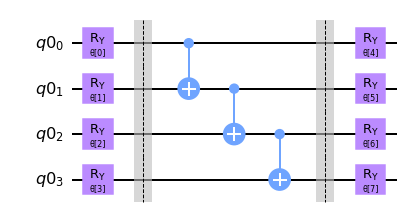

In [9]:
ansatz = RealAmplitudes_m(4, entanglement='linear', reps=1, insert_barriers=True, skip_final_rotation_layer=False)
ansatz.draw('mpl')

### 2.optimizer

In [ ]:
from qiskit.algorithms.optimizers import COBYLA
### 2. optimizer
optimizer = COBYLA(maxiter=50)

In [ ]:
### ???

### 3.backend

In [ ]:
from qiskit.utils import QuantumInstance
from qiskit import execute, Aer
### 3. backend
backend = "aer_simulator"
backend = QuantumInstance(
    Aer.get_backend(backend),
    shots=1000,
)

### callback function
counts = []
values = []

def callback_function(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    

### 4.expectation

In [ ]:
from qiskit.opflow import PauliExpectation, CVaRExpectation
### expectation
cvar_exp = CVaRExpectation(0.1, PauliExpectation())


In [ ]:
### ???

In [ ]:
from qiskit.algorithms import VQE
### VQE using CVaR
vqe = VQE(
    expectation=cvar_exp,
    optimizer=optimizer,
    ansatz=ansatz,
    quantum_instance=backend,
    callback=callback_function,
)

In [ ]:
### ???

# iv.AnalysingTheResults

In [ ]:
result = vqe.compute_minimum_eigenvalue(qubit_operations_1)
print(result)

### Plot the results

In [ ]:
import matplotlib.pyplot as plt

figure = plt.figure()

plt.plot(counts, values)
plt.ylabel("Conformation Energy")
plt.xlabel("VQE Iterations")

plt.show()